<a href="https://colab.research.google.com/github/GanesH2O/Downscale-GRACE/blob/main/03_0_Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load necessary

## Install and import necessary packages

In [ ]:
!pip install geedim
!pip install xarray rioxarray rasterio netCDF4
!pip install cartopy

In [ ]:
import geedim
import geemap
import geopandas as gpd
import ee
import os
import re
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nepal_shp = gpd.read_file('/content/drive/MyDrive/Paperwork/SHP/AOI.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')
world_shp = gpd.read_file('/content/drive/MyDrive/Paperwork/SHP/world-administrative-boundaries.shp')
world_shp = world_shp.set_crs('epsg:4326')

# Downscaling Data

In [ ]:
x_min = 77.025
y_min = 24.025
x_max = 88.975
y_max = 29.975

## Precipitation (CHIRPS)

In [ ]:
CHIRPS = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/CHIRPS.nc')
          .rename({'latitude': 'y', 'longitude': 'x'})
          .rio.write_crs('epsg:4326')
          .sel(time=slice('2003-01-01', '2020-12-31')))
CHIRPS

<xarray.Dataset> Size: 25MB
Dimensions:      (time: 216, y: 121, x: 241)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
  * y            (y) float32 484B 24.02 24.07 24.12 24.17 ... 29.92 29.97 30.02
  * x            (x) float32 964B 77.02 77.08 77.12 77.17 ... 88.92 88.98 89.02
    spatial_ref  int64 8B 0
Data variables:
    precip       (time, y, x) float32 25MB ...
Attributes: (12/31)
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    creator_type:              person
    ...                        ...
    summary:                   This dataset has monthly averages of the Clima...
    time_coverage_end:         2021-01-01T00:00:00Z
    time_coverage_start:       2000-01-01T00:00:00Z
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       77.024994

<ipython-input-47-744567443d6e>:2: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  CHIRPS = CHIRPS.rio.set_crs('epsg:4326')


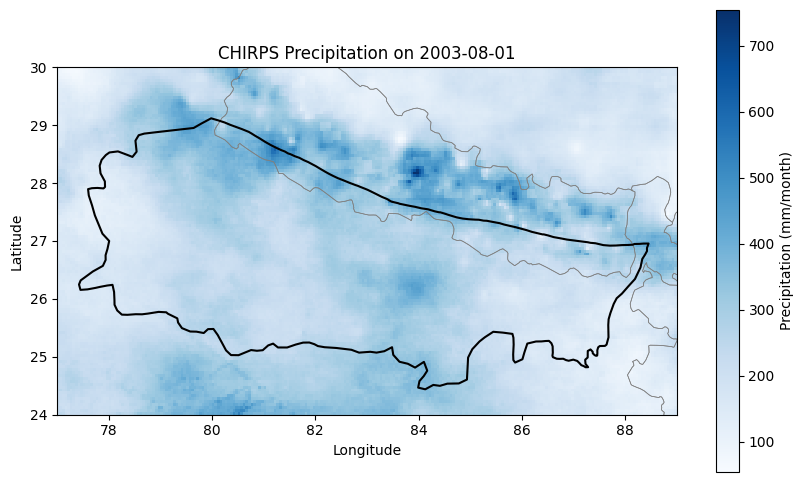

In [ ]:
# Assuming CHIRPS and nepal_shp are already loaded and processed
CHIRPS = CHIRPS.rio.set_crs('epsg:4326')
#CHIRPS = CHIRPS.rio.clip(nepal_shp.geometry, all_touched=True)
CHIRPS = CHIRPS.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = CHIRPS.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the CHIRPS precipitation data for the selected time
CHIRPSTR = CHIRPS.precip.isel(time=t).transpose('y', 'x')
CHIRPSTR.plot(ax=ax, cmap='Blues', add_colorbar=True, cbar_kwargs={'label': 'Precipitation (mm/month)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'CHIRPS Precipitation on {time_str}')

plt.show()

In [ ]:
#CHIRPS = CHIRPS.drop_vars('spatial_ref')
df_pr = CHIRPS['precip'].to_dataframe().reset_index()
df_pr = df_pr.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/PREDICTION/CHIRPS.csv'
df_pr.to_csv(output_csv_path, index=False)
df_pr

,time,y,x,spatial_ref,precip
0,2003-01-01,24.024994,77.024994,0,8.947807
240,2003-01-01,24.074997,77.024994,0,8.572832
480,2003-01-01,24.125000,77.024994,0,8.808331
720,2003-01-01,24.174995,77.024994,0,8.721972
960,2003-01-01,24.224998,77.024994,0,9.216493
...,...,...,...,...,...
6219839,2020-12-01,29.774994,88.975006,0,2.906559
6220079,2020-12-01,29.824997,88.975006,0,3.077884
6220319,2020-12-01,29.875000,88.975006,0,3.257809
6220559,2020-12-01,29.924995,88.975006,0,3.222049


## NDVI and EVI

In [ ]:
MOD = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/MOD13A3.061_1km_aid0001.nc')
          .rename({'lat': 'y', 'lon': 'x'})
          .rio.write_crs('epsg:4326')
          .sel(time=slice('2003-01-01', '2020-12-31'))
          .rename_vars({'_1_km_monthly_NDVI': 'NDVI'})
          .rename_vars({'_1_km_monthly_EVI': 'EVI'})
          .drop_vars('crs'))
MOD

<xarray.Dataset> Size: 5GB
Dimensions:                   (time: 216, y: 727, x: 1427)
Coordinates:
  * time                      (time) object 2kB 2003-01-01 00:00:00 ... 2020-...
  * y                         (y) float64 6kB 29.81 29.8 29.8 ... 23.77 23.76
  * x                         (x) float64 11kB 77.0 77.0 77.01 ... 88.87 88.88
Data variables:
    EVI                       (time, y, x) float64 2GB ...
    NDVI                      (time, y, x) float64 2GB ...
    _1_km_monthly_VI_Quality  (time, y, x) float64 2GB ...
Attributes:
    title:        MOD13A3.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.84
    references:   See README.md
    history:      See README.md

In [ ]:
regrid_lat = np.arange(24.025, 30.025, 0.05)
regrid_lon = np.arange(77.025, 89.025, 0.05)
MOD_05 = MOD.interp(x=regrid_lon, y=regrid_lat, method='slinear')

In [ ]:
MOD_05

<xarray.Dataset> Size: 149MB
Dimensions:                   (time: 216, y: 120, x: 240)
Coordinates:
  * time                      (time) object 2kB 2003-01-01 00:00:00 ... 2020-...
  * x                         (x) float64 2kB 77.03 77.08 77.12 ... 88.92 88.97
  * y                         (y) float64 960B 24.02 24.07 24.12 ... 29.93 29.98
Data variables:
    EVI                       (time, y, x) float64 50MB nan nan nan ... nan nan
    NDVI                      (time, y, x) float64 50MB nan nan nan ... nan nan
    _1_km_monthly_VI_Quality  (time, y, x) float64 50MB nan nan nan ... nan nan
Attributes:
    title:        MOD13A3.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.84
    references:   See README.md
    history:      See README.md

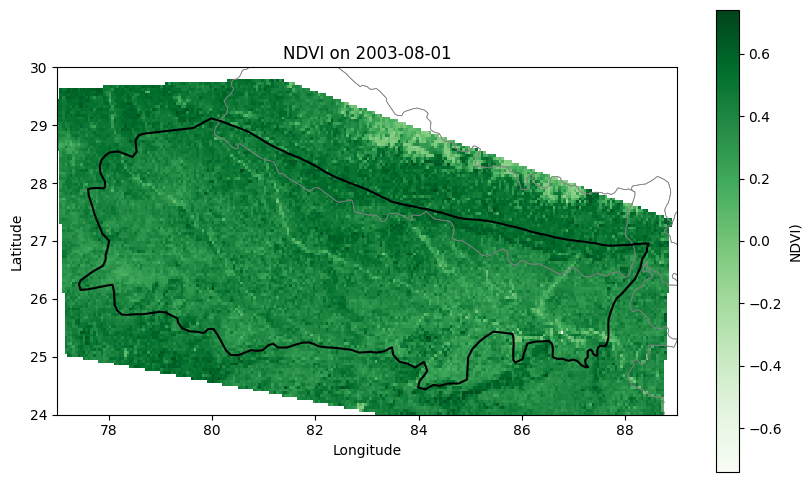

In [ ]:
# Assuming MOD and nepal_shp are already loaded and processed
MOD = MOD_05.rio.write_crs('epsg:4326')
#MOD = MOD.rio.clip(nepal_shp.geometry, all_touched=False)
MOD = MOD.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = MOD.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the MOD NDVIitation data for the selected time
MODTR = MOD.EVI.isel(time=t).transpose('y', 'x')
MODTR.plot(ax=ax, cmap='Greens', add_colorbar=True, cbar_kwargs={'label': 'NDVI)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'NDVI on {time_str}')

plt.show()

In [ ]:
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/PREDICTION/NDVI.csv'
df_mod = (MOD[['NDVI','EVI']]
          .to_dataframe()
          .reset_index()
          .sort_values(by=['time', 'x']))
df_mod.to_csv(output_csv_path, index=False)
df_mod

,time,y,x,NDVI,EVI,crs
0,2003-01-01 00:00:00,24.025,77.025,NaN,NaN,0
240,2003-01-01 00:00:00,24.075,77.025,NaN,NaN,0
480,2003-01-01 00:00:00,24.125,77.025,NaN,NaN,0
720,2003-01-01 00:00:00,24.175,77.025,NaN,NaN,0
960,2003-01-01 00:00:00,24.225,77.025,NaN,NaN,0
...,...,...,...,...,...,...
6219839,2020-12-01 00:00:00,29.775,88.975,NaN,NaN,0
6220079,2020-12-01 00:00:00,29.825,88.975,NaN,NaN,0
6220319,2020-12-01 00:00:00,29.875,88.975,NaN,NaN,0
6220559,2020-12-01 00:00:00,29.925,88.975,NaN,NaN,0



## LST

In [ ]:
LST = (xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/LST.nc')
          .sel(time=slice('2003-01-01', '2020-12-31'))
          .drop_vars('band')
          .drop_vars('spatial_ref'))
LST

<xarray.Dataset> Size: 5GB
Dimensions:    (x: 1677, y: 859, time: 216)
Coordinates:
  * x          (x) float64 13kB 77.0 77.01 77.02 77.02 ... 88.98 88.99 89.0
  * y          (y) float64 7kB 30.14 30.13 30.12 30.12 ... 24.02 24.01 24.0 24.0
  * time       (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    lst_day    (time, y, x) float64 2GB ...
    lst_night  (time, y, x) float64 2GB ...

In [ ]:
# Working on Chunks
LST_chunked = LST.chunk({'time': 12}) # Adjust chunk size as needed

    # Apply scaling (still on the chunked data)
LST_chunked['lst_day'] = LST_chunked['lst_day'] * 0.1
LST_chunked['lst_night'] = LST_chunked['lst_night'] * 0.1

    # Define regridding coordinates
regrid_lat = np.arange(24.025, 30.025, 0.05)
regrid_lon = np.arange(77.025, 89.025, 0.05)

    # Perform interpolation. Dask will handle processing in chunks.
LST_05 = LST_chunked.interp(x=regrid_lon, y=regrid_lat, method='slinear')
LST_05

    # Save the chunked result (this will also trigger computation)
LST_05.to_netcdf('/content/drive/MyDrive/Paperwork/DATA/0.05/LST_05.nc')

In [ ]:
LST_05 = xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/0.05/LST_05.nc')
LST_05 = LST_05.rio.write_crs('epsg:4326')
LST_05 = LST_05.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
LST_05 = LST_05.drop_vars('spatial_ref')
df_lst = LST_05[['lst_day','lst_night']].to_dataframe().reset_index()
df_lst = df_lst.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/PREDICTION/LST.csv'
df_lst.to_csv(output_csv_path, index=False)
df_lst

,time,y,x,lst_day,lst_night
0,2003-01-01,24.025,77.025,37.110084,9.284099
240,2003-01-01,24.075,77.025,35.760074,9.946886
480,2003-01-01,24.125,77.025,35.258711,8.563010
720,2003-01-01,24.175,77.025,35.914100,8.933488
960,2003-01-01,24.225,77.025,34.895754,8.999677
...,...,...,...,...,...
6219839,2020-12-01,29.775,88.975,9.477253,-17.900564
6220079,2020-12-01,29.825,88.975,14.361601,-17.356062
6220319,2020-12-01,29.875,88.975,11.144245,-15.807066
6220559,2020-12-01,29.925,88.975,6.543116,-17.656671


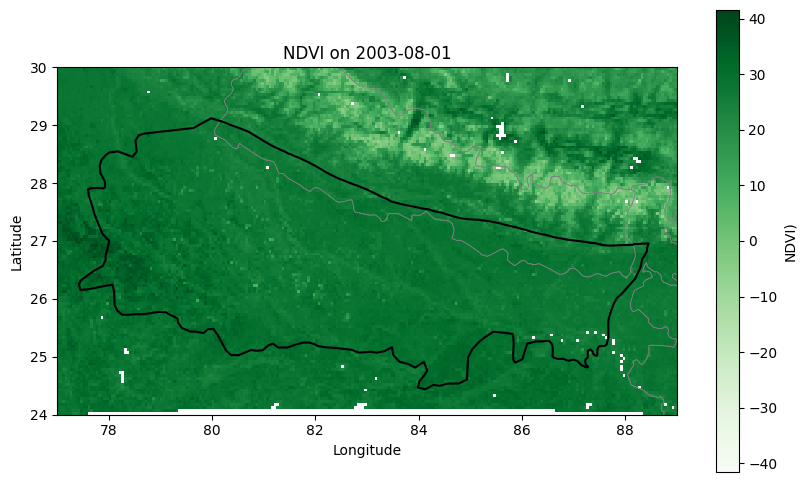

In [ ]:
LST_05 = LST_05.rio.write_crs('epsg:4326')
#LST_05 = LST_05.rio.clip(nepal_shp.geometry, all_touched=False)
LST_05 = LST_05.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = LST_05.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the LST_05 NDVIitation data for the selected time
LST_05TR = LST_05.lst_day.isel(time=t).transpose('y', 'x')
LST_05TR.plot(ax=ax, cmap='Greens', add_colorbar=True, cbar_kwargs={'label': 'NDVI)'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'NDVI on {time_str}')

plt.show()

## Population Density

In [ ]:
file_path = "/content/drive/MyDrive/Paperwork/DATA/LANDSCAN_combined_interpolated.nc"
ds = xr.open_dataset(file_path)
ds = ds.reindex(y=np.sort(ds["y"].values))
# Select the population variable (adjust variable name if different)
pop_data = ds["population"]  # Shape: (time, lat, lon)

# Downscale to 0.05
pop_aggregated = pop_data.coarsen(x=6, y=6, boundary="trim").sum()
#downscale to 0.1 degree
#pop_aggregated = pop_data.coarsen(x=12, y=12, boundary="trim").sum()
pop_aggregated

<xarray.DataArray 'population' (time: 241, y: 122, x: 240)> Size: 56MB
array([[[2.85100e+03, 2.46800e+03, 2.94200e+03, ..., 3.75100e+04,
         3.01090e+04, 1.18884e+05],
        [3.18300e+03, 3.36400e+03, 2.78800e+03, ..., 1.17950e+04,
         1.20710e+04, 1.01450e+04],
        [8.22600e+03, 2.31000e+03, 2.73600e+03, ..., 1.57140e+04,
         6.37700e+03, 5.35300e+03],
        ...,
        [1.12160e+04, 3.83940e+04, 9.77200e+03, ..., 2.50000e+01,
         3.50000e+01, 5.40000e+01],
        [1.02600e+03, 2.02100e+03, 1.30900e+03, ..., 5.00000e+00,
         8.00000e+00, 2.10000e+01],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[2.84500e+03, 2.44200e+03, 2.93600e+03, ..., 3.75390e+04,
         3.01380e+04, 1.19093e+05],
        [3.17600e+03, 3.35700e+03, 2.78300e+03, ..., 1.17970e+04,
         1.20750e+04, 1.01830e+04],
        [8.20700e+03, 2.30600e+03, 2.73100e+03, ..., 1.61310e+04,
         6.31500e+03, 5.33500e+03],
...
        [1.38060e+04, 4.40520e+04, 1.26370e+04, ..., 1.00000e+00,
         0.00000e+00, 3.10000e+01],
        [1.89000e+03, 2.11100e+03, 2.71900e+03, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[5.36300e+03, 5.02700e+03, 5.57400e+03, ..., 4.65390e+04,
         4.72010e+04, 7.62710e+04],
        [4.45500e+03, 4.67500e+03, 3.20400e+03, ..., 2.37800e+04,
         3.34130e+04, 3.46120e+04],
        [8.62500e+03, 4.13600e+03, 4.96800e+03, ..., 9.65200e+03,
         9.76900e+03, 1.89870e+04],
        ...,
        [1.38900e+04, 4.40230e+04, 1.26930e+04, ..., 1.00000e+00,
         0.00000e+00, 3.10000e+01],
        [1.87700e+03, 2.12000e+03, 2.73600e+03, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]])
Coordinates:
  * x        (x) float64 2kB 77.02 77.07 77.12 77.17 ... 88.82 88.87 88.92 88.97
  * y        (y) float64 976B 24.02 24.07 24.12 24.17 ... 29.97 30.02 30.07
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2023-01-01
    band     int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1
    grid_mapping:   spatial_ref

In [ ]:
#pop_density = pop_aggregated / (27.82987269831839*27.82987269831839) #for calculating density at 0.25
pop_density = pop_aggregated / (5.56597453966366**2) #for calculating density at 0.05
pop_density = pop_density.astype(int)  # Convert to integer
pop_density = pop_density.where(pop_density > 0, np.nan)
pop_density.name = "population_density"
pop_density

<xarray.DataArray 'population_density' (time: 241, y: 122, x: 240)> Size: 56MB
array([[[9.200e+01, 7.900e+01, 9.400e+01, ..., 1.210e+03, 9.710e+02,
         3.837e+03],
        [1.020e+02, 1.080e+02, 8.900e+01, ..., 3.800e+02, 3.890e+02,
         3.270e+02],
        [2.650e+02, 7.400e+01, 8.800e+01, ..., 5.070e+02, 2.050e+02,
         1.720e+02],
        ...,
        [3.620e+02, 1.239e+03, 3.150e+02, ...,       nan, 1.000e+00,
         1.000e+00],
        [3.300e+01, 6.500e+01, 4.200e+01, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[9.100e+01, 7.800e+01, 9.400e+01, ..., 1.211e+03, 9.720e+02,
         3.844e+03],
        [1.020e+02, 1.080e+02, 8.900e+01, ..., 3.800e+02, 3.890e+02,
         3.280e+02],
        [2.640e+02, 7.400e+01, 8.800e+01, ..., 5.200e+02, 2.030e+02,
         1.720e+02],
...
        [4.450e+02, 1.421e+03, 4.070e+02, ...,       nan,       nan,
         1.000e+00],
        [6.100e+01, 6.800e+01, 8.700e+01, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[1.730e+02, 1.620e+02, 1.790e+02, ..., 1.502e+03, 1.523e+03,
         2.461e+03],
        [1.430e+02, 1.500e+02, 1.030e+02, ..., 7.670e+02, 1.078e+03,
         1.117e+03],
        [2.780e+02, 1.330e+02, 1.600e+02, ..., 3.110e+02, 3.150e+02,
         6.120e+02],
        ...,
        [4.480e+02, 1.421e+03, 4.090e+02, ...,       nan,       nan,
         1.000e+00],
        [6.000e+01, 6.800e+01, 8.800e+01, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]])
Coordinates:
  * x        (x) float64 2kB 77.02 77.07 77.12 77.17 ... 88.82 88.87 88.92 88.97
  * y        (y) float64 976B 24.02 24.07 24.12 24.17 ... 29.97 30.02 30.07
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2023-01-01
    band     int64 8B 1

In [ ]:
#shift_x = 0.008333333
#x = pop_density.coords['x']+shift_x
#pop_density.coords['x'] = x

# Export to NetCDF with projection 4326
#output_file = "/content/drive/MyDrive/Thesis/REGRID/LANDSCAN_density_0.25.nc"
output_file = "/content/drive/MyDrive/Paperwork/DATA/0.05/LANDSCAN_density_0.05.nc"
pop_density = pop_density.rio.write_crs("EPSG:4326", inplace=True)
pop_density = pop_density.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
pop_density = pop_density.sel(time=slice('2003-01-01', '2020-12-31'))
pop_density.to_netcdf(output_file)
pop_density

<xarray.DataArray 'population_density' (time: 216, y: 120, x: 240)> Size: 50MB
array([[[9.200e+01, 7.900e+01, 9.400e+01, ..., 1.210e+03, 9.710e+02,
         3.837e+03],
        [1.020e+02, 1.080e+02, 8.900e+01, ..., 3.800e+02, 3.890e+02,
         3.270e+02],
        [2.650e+02, 7.400e+01, 8.800e+01, ..., 5.070e+02, 2.050e+02,
         1.720e+02],
        ...,
        [3.890e+02, 8.600e+02, 3.540e+02, ...,       nan, 2.000e+00,
         1.000e+00],
        [3.950e+02, 9.210e+02, 2.590e+02, ...,       nan, 1.000e+00,
         1.000e+00],
        [3.620e+02, 1.239e+03, 3.150e+02, ...,       nan, 1.000e+00,
         1.000e+00]],

       [[9.100e+01, 7.800e+01, 9.400e+01, ..., 1.211e+03, 9.720e+02,
         3.844e+03],
        [1.020e+02, 1.080e+02, 8.900e+01, ..., 3.800e+02, 3.890e+02,
         3.280e+02],
        [2.640e+02, 7.400e+01, 8.800e+01, ..., 5.200e+02, 2.030e+02,
         1.720e+02],
...
        [3.740e+02, 7.650e+02, 3.020e+02, ...,       nan, 2.000e+00,
         1.000e+00],
        [3.120e+02, 6.240e+02, 2.730e+02, ...,       nan,       nan,
               nan],
        [4.000e+02, 1.380e+03, 3.760e+02, ...,       nan,       nan,
               nan]],

       [[2.220e+02, 1.380e+02, 1.630e+02, ..., 1.507e+03, 1.430e+03,
         2.979e+03],
        [1.250e+02, 1.560e+02, 7.700e+01, ..., 7.200e+02, 9.540e+02,
         1.007e+03],
        [3.040e+02, 9.200e+01, 9.000e+01, ..., 4.280e+02, 2.270e+02,
         4.590e+02],
        ...,
        [3.750e+02, 7.660e+02, 3.020e+02, ...,       nan, 2.000e+00,
         1.000e+00],
        [3.120e+02, 6.250e+02, 2.730e+02, ...,       nan,       nan,
               nan],
        [4.000e+02, 1.382e+03, 3.760e+02, ...,       nan,       nan,
               nan]]])
Coordinates:
  * x            (x) float64 2kB 77.02 77.07 77.12 77.17 ... 88.87 88.92 88.97
  * y            (y) float64 960B 24.02 24.07 24.12 24.17 ... 29.87 29.92 29.97
  * time         (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2020-12-01
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [ ]:
pop_density = xr.open_dataset('/content/drive/MyDrive/Paperwork/DATA/0.05/LANDSCAN_density_0.05.nc')
pop_density = pop_density.rio.write_crs('epsg:4326')
pop_density = pop_density.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
pop_density = pop_density.sel(time=slice('2003-01-01', '2020-12-31'))

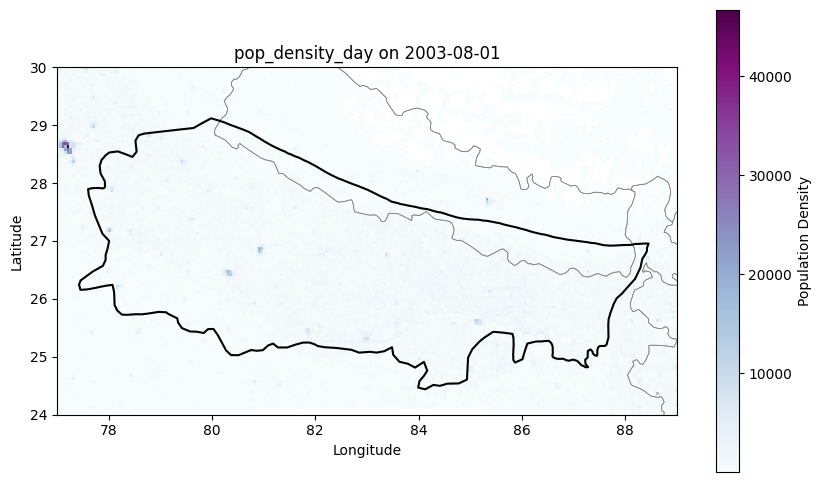

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
t = 7
time_stamp = pop_density.time.isel(time=t).values
# Format the timestamp (adjust format as needed)
time_str = str(time_stamp)[:10]
# Transpose and plot the pop_density pop_density_dayitation data for the selected time
pop_densityTR = pop_density.isel(time=t).transpose('y', 'x')
pop_densityTR['population_density'].plot.imshow(ax=ax, cmap='BuPu', add_colorbar=True, cbar_kwargs={'label': 'Population Density'})

# Plot the world administrative boundaries
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)

# Plot the Nepal shapefile on top to highlight it
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=1.5)

# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'pop_density_day on {time_str}')

plt.show()

In [ ]:
pop_density = pop_density.drop_vars(['spatial_ref','band'])
df_pop = pop_density.to_dataframe().reset_index()
df_pop = df_pop.sort_values(by=['time', 'x'])
output_csv_path = '/content/drive/MyDrive/Paperwork/RFM/PREDICTION/population.csv'
df_pop.to_csv(output_csv_path, index=False)
df_pop

,x,y,time,population_density
0,77.016667,24.025,2003-01-01,92.0
216,77.016667,24.075,2003-01-01,102.0
432,77.016667,24.125,2003-01-01,265.0
648,77.016667,24.175,2003-01-01,259.0
864,77.016667,24.225,2003-01-01,179.0
...,...,...,...,...
6219935,88.966667,29.775,2020-12-01,NaN
6220151,88.966667,29.825,2020-12-01,1.0
6220367,88.966667,29.875,2020-12-01,1.0
6220583,88.966667,29.925,2020-12-01,NaN


## Topo Variables

### Elevation

In [ ]:
dem_file = "/content/drive/MyDrive/Paperwork/DATA/0.05/DEM 0.05.tif"
dem = rioxarray.open_rasterio(dem_file)
dem = dem.squeeze(dim="band", drop=True)
dem = dem.rio.clip_box(minx=x_min, miny=y_min, maxx=x_max, maxy=y_max)
dem

<xarray.DataArray (y: 120, x: 240)> Size: 58kB
[28800 values with dtype=int16]
Coordinates:
  * x            (x) float64 2kB 77.02 77.07 77.12 77.17 ... 88.87 88.92 88.97
  * y            (y) float64 960B 29.98 29.93 29.88 29.83 ... 24.13 24.08 24.03
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768

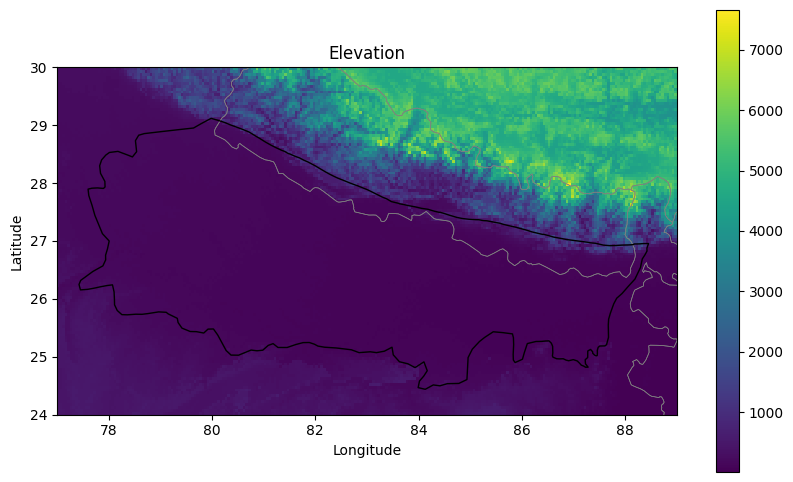

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fill_value = -32768
dem_masked = dem.where(dem != fill_value)
dem_tr = dem_masked.transpose('y', 'x')
dem_tr.plot(ax=ax)
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')
# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'Elevation')
plt.show()

In [ ]:
dem.name = "elevation"
demdf = dem.to_dataframe().reset_index()
demdf = demdf.sort_values(by=['x','y'])
demdf
# Export to CSV
demdf.to_csv('/content/drive/MyDrive/Paperwork/RFM/PREDICTION/DEM/elevation.csv', index=False)
demdf

,y,x,spatial_ref,elevation
28560,24.025139,77.024861,0,411
28320,24.075139,77.024861,0,429
28080,24.125139,77.024861,0,432
27840,24.175139,77.024861,0,427
27600,24.225139,77.024861,0,448
...,...,...,...,...
1199,29.775139,88.974861,0,5169
959,29.825139,88.974861,0,4723
719,29.875139,88.974861,0,4731
479,29.925139,88.974861,0,5362


### Slope

In [ ]:
slope_file = "/content/drive/MyDrive/Paperwork/DATA/0.5/SLOPE 0.5.tif"
slope = rioxarray.open_rasterio(slope_file)
slope = slope.rio.clip(nepal_shp.geometry,all_touched= True)
slope = slope.squeeze(dim=("band"), drop=True)
slope.name = "slope" # This sets the name of the DataArray, which will become the column name in the DataFrame

# Convert the DataArray directly to a DataFrame.
# The DataArray's name ('slope') will be used as the column name.
slopedf = slope.to_dataframe().reset_index()
slopedf = slopedf[['x', 'y', 'slope']]
slopedf = slopedf.sort_values(by=['x','y'])
# Export to CSV
#slopedf.to_csv('/content/drive/MyDrive/Paperwork/RFM/TRAINING/DEM/SLOPE.csv', index=False)
slopedf

,x,y,slope
230,77.249861,24.250139,-9999.0
207,77.249861,24.750139,-9999.0
184,77.249861,25.250139,-9999.0
161,77.249861,25.750139,-9999.0
138,77.249861,26.250139,-9999.0
...,...,...,...
114,88.249861,27.250139,-9999.0
91,88.249861,27.750139,-9999.0
68,88.249861,28.250139,-9999.0
45,88.249861,28.750139,-9999.0


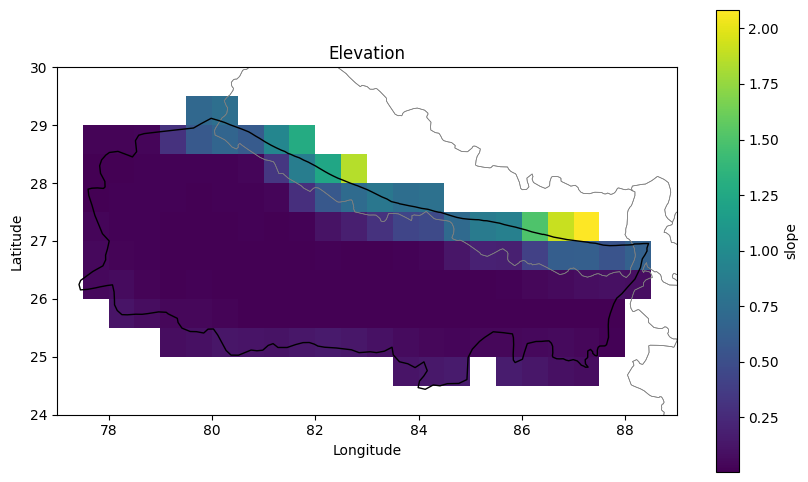

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fill_value = -9999
slope_masked = slope.where(slope != fill_value)
slope_tr = slope_masked.transpose('y', 'x')
slope_tr.plot(ax=ax)
world_shp.plot(ax=ax, edgecolor='gray', facecolor='None', linewidth=0.5)
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')
# Set plot limits to focus on Nepal
ax.set_xlim([77, 89])  # Approximate longitude range for Nepal
ax.set_ylim([24, 30])  # Approximate latitude range for Nepal

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title(f'Elevation')
plt.show()

In [ ]:
import pandas as pd
import os

# Folder containing the CSV files
input_folder = f'/content/drive/MyDrive/Paperwork/RFM/PREDICTION/DEM'
output_folder = f'/content/drive/MyDrive/Paperwork/RFM/PREDICTION'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Step 2: Create a date range from 2003-02-01 to 2016-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-01-01', end='2020-12-31', freq='MS')
# Loop through each CSV file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Step 1: Read each original CSV file
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_csv(file_path)

        # Step 5: Repeat the original data for each valid date (excluding the missing ones)
        extended_data = pd.concat([original_data] * len(date_range), ignore_index=True)
        extended_data['time'] = date_range.repeat(len(original_data)).values

        # Step 6: Export the new data with the time dimension to a new CSV file
        output_file = os.path.join(output_folder, f'extended_{file_name}')
        extended_data.to_csv(output_file, index=False)

        print(f"Processed and saved {output_file}")

print("All files have been processed and saved.")

Processed and saved /content/drive/MyDrive/Paperwork/RFM/PREDICTION/extended_elevation.csv
All files have been processed and saved.


# Check and Combine

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = f'/content/drive/MyDrive/Paperwork/RFM/PREDICTION'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')

File: CHIRPS.csv, Number of rows: 6220800
File: NDVI.csv, Number of rows: 6220800
File: LST.csv, Number of rows: 6220800
File: population.csv, Number of rows: 6220800
File: extended_elevation.csv, Number of rows: 6220800


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Paperwork/RFM/PREDICTION/RFM_PREDICTION.csv'

In [ ]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = '/content/drive/MyDrive/Paperwork/RFM/PREDICTION'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each CSV file and display its first few rows
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(file_path)  # Read the CSV file
        print(f"Preview of {file}:")
        print(df.head())  # Display first 5 rows
        print("\n" + "-"*50 + "\n")  # Separator for better readability
    except Exception as e:
        print(f"Could not read {file}: {e}")

Preview of CHIRPS.csv:
         time          y          x  spatial_ref    precip
0  2003-01-01  24.024994  77.024994            0  8.947807
1  2003-01-01  24.074997  77.024994            0  8.572832
2  2003-01-01  24.125000  77.024994            0  8.808331
3  2003-01-01  24.174995  77.024994            0  8.721972
4  2003-01-01  24.224998  77.024994            0  9.216493

--------------------------------------------------

Preview of NDVI.csv:
                  time       y       x  NDVI  EVI  crs
0  2003-01-01 00:00:00  24.025  77.025   NaN  NaN    0
1  2003-01-01 00:00:00  24.075  77.025   NaN  NaN    0
2  2003-01-01 00:00:00  24.125  77.025   NaN  NaN    0
3  2003-01-01 00:00:00  24.175  77.025   NaN  NaN    0
4  2003-01-01 00:00:00  24.225  77.025   NaN  NaN    0

--------------------------------------------------

Preview of LST.csv:
         time       y       x    lst_day  lst_night
0  2003-01-01  24.025  77.025  37.110084   9.284099
1  2003-01-01  24.075  77.025  35.760074  

In [ ]:
# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = f'/content/drive/MyDrive/Paperwork/RFM/PREDICTION'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(f"/content/drive/MyDrive/Paperwork/RFM/PREDICTION/RFM_PREDICTION.csv", index=False)
print("Combined CSV file created")

Available columns in CHIRPS.csv:
['time', 'y', 'x', 'spatial_ref', 'precip']
Enter the columns to copy (separated by commas): time, x, y, precip
Available columns in NDVI.csv:
['time', 'y', 'x', 'NDVI', 'EVI', 'crs']
Enter the columns to copy (separated by commas): NDVI, EVI
Available columns in LST.csv:
['time', 'y', 'x', 'lst_day', 'lst_night']
Enter the columns to copy (separated by commas): lst_day, lst_night
Available columns in population.csv:
['x', 'y', 'time', 'population_density']
Enter the columns to copy (separated by commas): population_density
Available columns in extended_elevation.csv:
['y', 'x', 'spatial_ref', 'elevation', 'time']
Enter the columns to copy (separated by commas): elevation
Combined CSV file created
